# LAB 5: ONNX
### AI and Machine Learning // Suchkova Natalia М8О - 114М - 22
16.06.23 @ MAI IT-Center

### The Task
1. Обучить нейросеть
2. Pruning
3. Конвертировать в ONNX

In [109]:
!pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 89.5 MB/s eta 0:00:00


In [110]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.onnx
import torchvision
from torch.optim import Adam
from torch.autograd import Variable



from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T

In [111]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ONNX (Open Neural Network Exchange) — открытая библиотека программного обеспечения для построения нейронных сетей глубокого обучения. С помощью ONNX ИИ-разработчики могут обмениваться моделями между различными инструментами и выбирать наилучшую комбинацию этих инструментов. ONNX разрабатывается и поддерживается совместно компаниями Microsoft, Facebook, Amazon и другими партнерами как проект с открытым исходным кодом

### Сеть

In [112]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 10)

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = F.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = F.relu(output)
        output = self.pool(output)

        output = self.conv4(output)
        output = self.bn4(output)
        output = F.relu(output)

        output = self.conv5(output)
        output = self.bn5(output)
        output = F.relu(output)

        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output

In [113]:
IMG_SIZE = 32
BATCH_SIZE = 10
number_of_labels = 10

# input_size = (3, 64, 64)

# classes = ('T-shirt/top',
#           'Trouser',
#           'Pullover',
#           'Dress',
#           'Coat',
#           'Sandal',
#           'Shirt',
#           'Sneaker',
#           'Bag',
#           'Ankle boot')

batch_size = 10
number_of_labels = 10

input_size = (3, 32, 32)

classes = ('plane',
           'car',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')


# Instantiate a neural network model
model = Network()

# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

### Загружаем данные

In [114]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set =CIFAR10(root="./data",train=True,transform=transformations,download=True)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
print("The number of images in a training set is: ", len(train_loader)*batch_size)

test_set = CIFAR10(root="./data", train=False, transform=transformations, download=True)

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
print("The number of images in a test set is: ", len(test_loader)*batch_size)

print("The number of batches per epoch is: ", len(train_loader))

Files already downloaded and verified
The number of images in a training set is:  50000
Files already downloaded and verified
The number of images in a test set is:  10000
The number of batches per epoch is:  5000


In [115]:
# train_transforms = T.Compose([
#     T.Resize(IMG_SIZE),
#     T.RandomVerticalFlip(p=0.5),
#     T.RandomHorizontalFlip(p=0.5),
#     T.ToTensor(),
# ])
# val_transforms = T.Compose([
#     T.Resize(IMG_SIZE),
#     T.ToTensor(),
# ])

In [116]:
# train_data = datasets.FashionMNIST(root="../datasets", train=True, download=True,transform=train_transforms)
# test_data = datasets.FashionMNIST(root="../datasets", train=False, download=True,transform=val_transforms)
# train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True, drop_last=True, shuffle=True,)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True, drop_last=True, shuffle=True)

In [117]:
# print("The number of images in a test set is: ", len(test_loader) * BATCH_SIZE)

# print("The number of batches per epoch is: ", len(train_loader))

In [118]:
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [119]:
# Function to Convert to ONNX
def Convert_ONNX():

    # set the model to inference mode
    model.eval()

    # Let's create a dummy input tensor
    dummy_input = torch.randn(1, *input_size, requires_grad=True)

    torch.onnx.export(
        model,                                 # model being run
        dummy_input,                           # model input (or a tuple for multiple inputs)
        "ImageClassifier.onnx",                # where to save the model
        export_params=True,                    # store the trained parameter weights inside the model file
        opset_version=10,                      # the ONNX version to export the model to
        do_constant_folding=True,              # whether to execute constant folding for optimization
        input_names = ['modelInput'],          # the model's input names
        output_names = ['modelOutput'],        # the model's output names
        dynamic_axes={                         # variable length axes
            'modelInput' : {0 : 'batch_size'},
            'modelOutput' : {0 : 'batch_size'}
        })

    print(" ")
    print('Model has been converted to ONNX')

In [120]:
# Function to save the model
def saveModel():
    path = "./model_cifar.pth"
    torch.save(model.state_dict(), path)

In [121]:
# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():

    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    accuracy = (100 * accuracy / total)
    return(accuracy)

In [122]:
# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    images, labels = next(iter(test_loader))

    imageshow(torchvision.utils.make_grid(images))

    print('Real labels: ', ' '.join('%5s' % classes[labels[j]]
                               for j in range(BATCH_SIZE)))

    outputs = model(images)

    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(BATCH_SIZE)))

In [123]:
def testClassess():
    class_correct = list(0. for i in range(number_of_labels))
    class_total = list(0. for i in range(number_of_labels))

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()

            for i in range(BATCH_SIZE):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(number_of_labels):
        print('Accuracy of %5s : %2d %%' % (classes[i],
                                            100 * class_correct[i] / class_total[i]))

In [124]:
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    best_accuracy = 0.0

    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):

            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

        for i, (images, labels) in enumerate(train_loader, 0):

            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            if i % 1000 == 999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0

        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))

        if accuracy > best_accuracy:
           saveModel()
           best_accuracy = accuracy

[1,  1000] loss: 1.804
[1,  2000] loss: 1.485
[1,  3000] loss: 1.316
[1,  4000] loss: 1.221
[1,  5000] loss: 1.150
For epoch 1 the test accuracy over the whole test set is 61 %
[2,  1000] loss: 1.089
[2,  2000] loss: 1.017
[2,  3000] loss: 1.012
[2,  4000] loss: 0.989
[2,  5000] loss: 0.968
For epoch 2 the test accuracy over the whole test set is 66 %
[3,  1000] loss: 0.880
[3,  2000] loss: 0.899
[3,  3000] loss: 0.881
[3,  4000] loss: 0.895
[3,  5000] loss: 0.883
For epoch 3 the test accuracy over the whole test set is 68 %
[4,  1000] loss: 0.789
[4,  2000] loss: 0.815
[4,  3000] loss: 0.809
[4,  4000] loss: 0.822
[4,  5000] loss: 0.824
For epoch 4 the test accuracy over the whole test set is 69 %
[5,  1000] loss: 0.725
[5,  2000] loss: 0.756
[5,  3000] loss: 0.741
[5,  4000] loss: 0.775
[5,  5000] loss: 0.763
For epoch 5 the test accuracy over the whole test set is 70 %
Finished Training
Accuracy of plane : 76 %
Accuracy of   car : 73 %
Accuracy of  bird : 50 %
Accuracy of   cat : 60

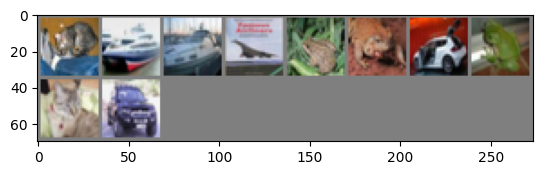

Real labels:    cat  ship  ship plane  frog  frog   car  frog   cat   car
Predicted:    cat  ship  ship plane  frog  frog   dog  bird   cat   car
============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

 
Model has been converted to ONNX


In [125]:
train(5)
print('Finished Training')

testAccuracy()
testClassess()

model = Network()
path = "model_cifar.pth"
model.load_state_dict(torch.load(path))

testBatch()

# Conversion to ONNX
Convert_ONNX()